# German Traffic Sign Recognition

The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:

- Single-image, multi-class classification problem
- More than 40 classes
- More than 50,000 images in total
- Large, lifelike database

## PLAN

### 1.1 Import Package and Data

In [1]:
import pandas as pd
import numpy as np
import kagglehub
import os
from PIL import Image
from PIL import ImageOps
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

import warnings

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-10 23:52:13.311458: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-10 23:52:13.432326: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-10 23:52:13.495051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731282733.577179    1827 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731282733.600145    1827 cuda_blas.cc:1418] Una

In [2]:
# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Path to dataset files:", path)

Path to dataset files: /home/codespace/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


In [3]:
# Data path
dataset_path = os.path.join(path, "/home/codespace/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1")

# List files in the dataset directory
files = os.listdir(dataset_path)
print("Files in dataset directory:", files)

Files in dataset directory: ['Train', 'Meta', 'Test.csv', 'Train.csv', 'Meta.csv', 'meta', 'Test', 'test', 'train', 'ResizedTest', 'ResizedTrain']


In [4]:
# Load the dataset
df = pd.read_csv(os.path.join(dataset_path, "Train.csv"))
df_test = pd.read_csv(os.path.join(dataset_path, "Test.csv"))
meta = pd.read_csv(os.path.join(dataset_path, "Meta.csv"))

print("Training dataset:")
print(df.head())

print("\nTest dataset:")
print(df_test.head())

print("\nMeta dataset:")
print(meta.head())


Training dataset:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  

Test dataset:
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      

## ANALYZE

### 2.1 Understand the Data

Our goal is to use the training set to determine the different categories of traffic signs. The `Meta` folder has 42 categories, also labeled on the train set. Let's first display that category and then display some training samples.

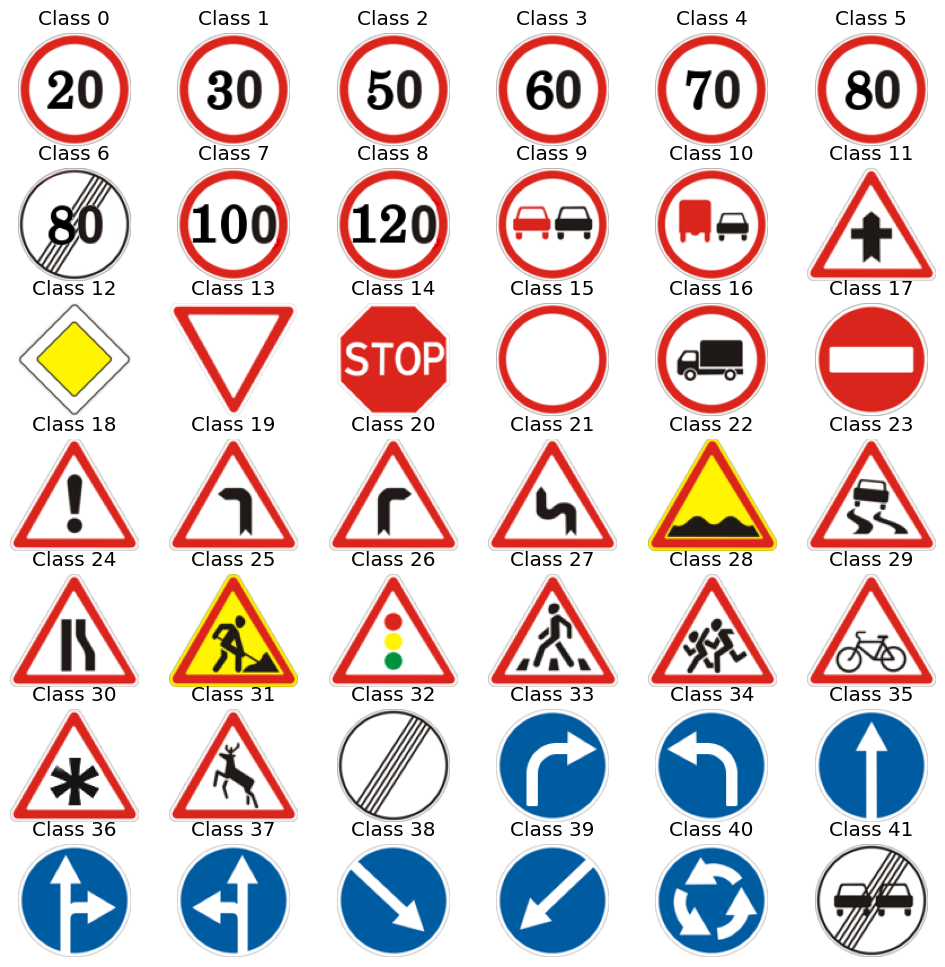

In [5]:
# Show all 42 images in meta dataset
# Rank the classes from 0 to 42 before displaying
meta_sorted = meta.sort_values(by="ClassId").reset_index(drop=True)

fig, axs = plt.subplots(7, 6, figsize=(12, 12))
for i in range(42):
    img_path = os.path.join(dataset_path, meta_sorted.iloc[i]["Path"])
    img = Image.open(img_path)
    axs[i // 6, i % 6].imshow(img)
    axs[i // 6, i % 6].axis("off")
    axs[i // 6, i % 6].set_title(f"Class {meta_sorted.iloc[i]["ClassId"]}")
plt.show()

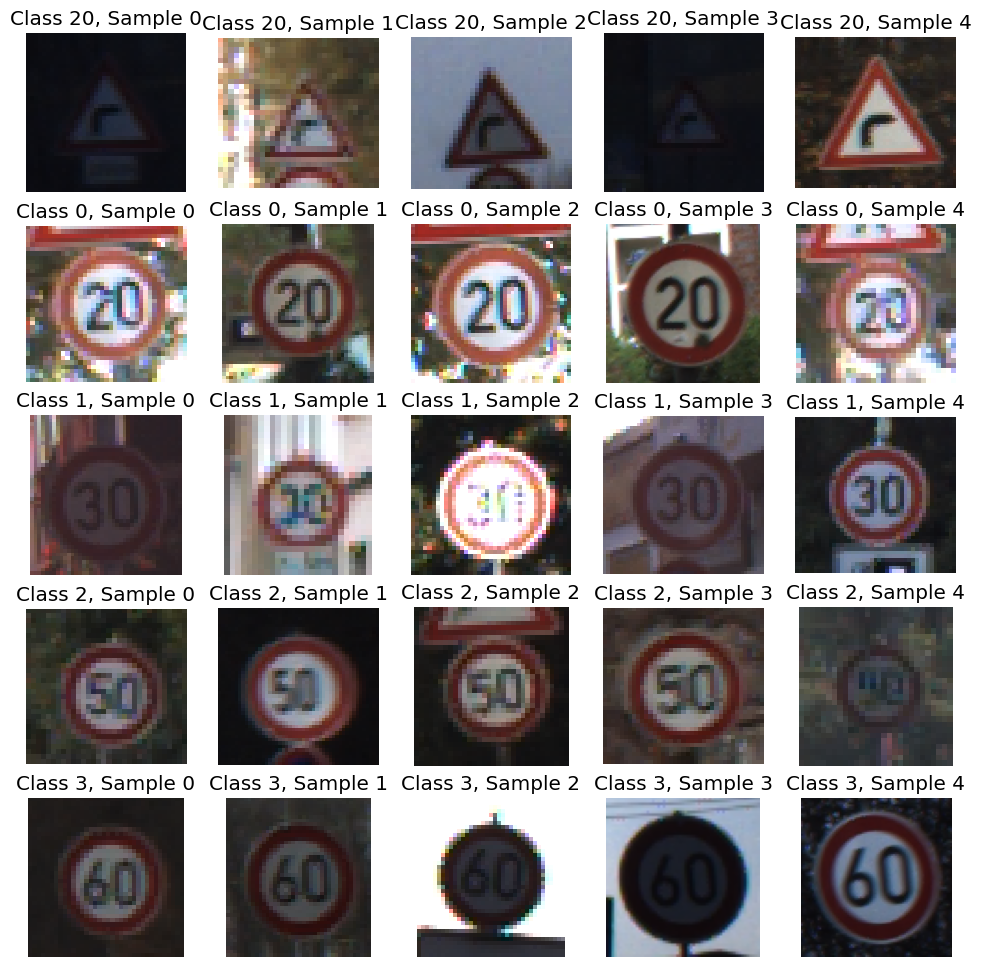

In [6]:
# Show first 5 images from the 5 folder in training dataset
unique_classes = df["ClassId"].unique()[:5] 

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, class_id in enumerate(unique_classes):
    class_samples = df[df["ClassId"] == class_id].sample(5, random_state=1) 
    for j in range(5):
        img_path = os.path.join(dataset_path, class_samples.iloc[j]["Path"])
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis("off")
        axs[i, j].set_title(f"Class {class_id}, Sample {j}")
plt.show()


## CONSTRUCT

### 3.1 Data Processing

The input image in the training set has a different resolution. In this case, we must reshape them to the exact shape to feed into the model. And the output will be 42 categories. 

To determine what size we should reshape. Let's first get the average and median for height and weight.

In [7]:
# Get the average and median width and height of the images in the training dataset
df["Width"] = df["Width"].astype(int)
df["Height"] = df["Height"].astype(int)

print("Average width:", df["Width"].mean())
print("Average height:", df["Height"].mean())
print("Median width:", df["Width"].median())
print("Median height:", df["Height"].median())

Average width: 50.83587951745773
Average height: 50.328929582493814
Median width: 43.0
Median height: 43.0


Let's use 43 x 43 as the initial try and see the performance.

In [8]:
# Reshape the images to 43x43 pixels
def resize_image(img_path):
    img = Image.open(img_path)
    img = ImageOps.fit(img, (43, 43), Image.LANCZOS)
    return img

# Resize the images in the training dataset
df["ResizedPath"] = df["Path"].apply(lambda x: x.replace("Train", "ResizedTrain"))
os.makedirs(os.path.join(dataset_path, "ResizedTrain"), exist_ok=True)

for i in range(len(df)):
    img_path = os.path.join(dataset_path, df.iloc[i]["Path"])
    resized_img_path = os.path.join(dataset_path, df.iloc[i]["ResizedPath"])
    os.makedirs(os.path.dirname(resized_img_path), exist_ok=True)
    resized_img = resize_image(img_path)
    resized_img.save(resized_img_path)
    
# Resize the images in the test dataset
df_test["ResizedPath"] = df_test["Path"].apply(lambda x: x.replace("Test", "ResizedTest"))
os.makedirs(os.path.join(dataset_path, "ResizedTest"), exist_ok=True)

for i in range(len(df_test)):
    img_path = os.path.join(dataset_path, df_test.iloc[i]["Path"])
    resized_img_path = os.path.join(dataset_path, df_test.iloc[i]["ResizedPath"])
    os.makedirs(os.path.dirname(resized_img_path), exist_ok=True)
    resized_img = resize_image(img_path)
    resized_img.save(resized_img_path)
    
# Print out the shape of the resized images
img = Image.open(os.path.join(dataset_path, df.iloc[0]["ResizedPath"]))
print("Resized image shape:", np.array(img).shape)

Resized image shape: (43, 43, 3)


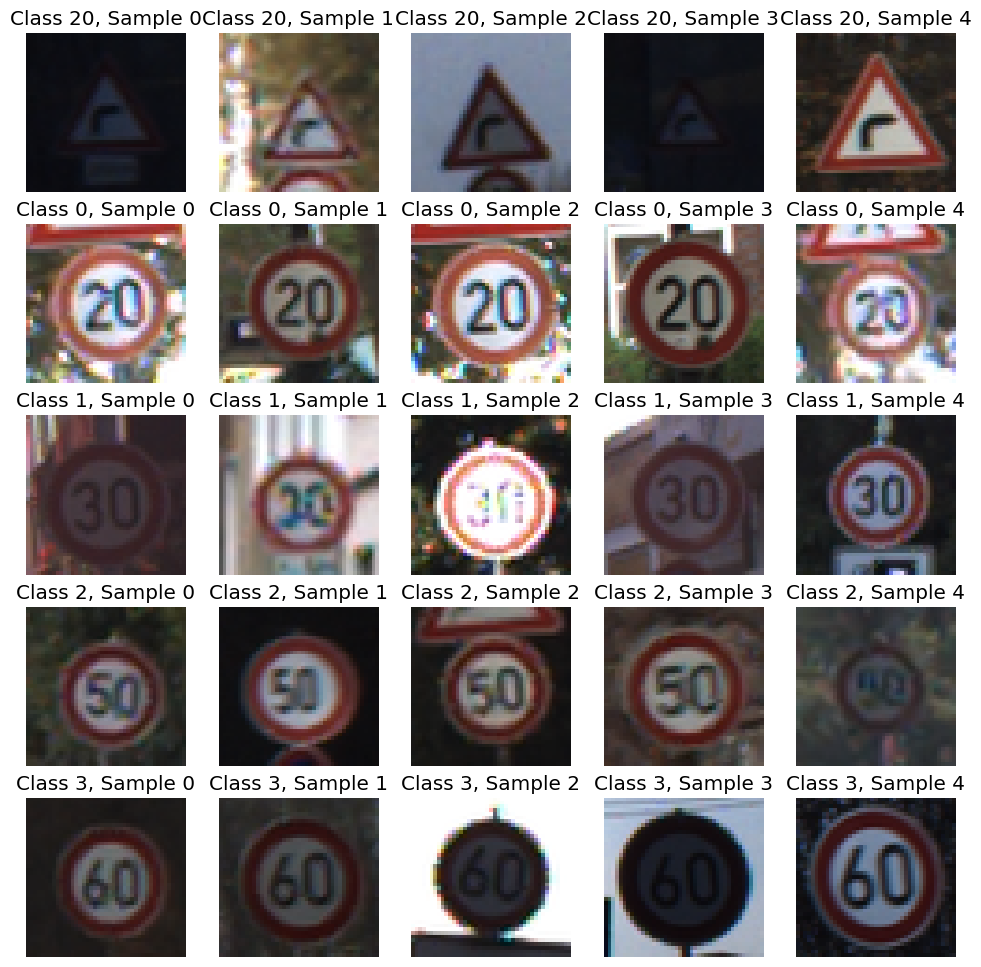

In [9]:
# Show first 5 images from the 5 folder in training dataset
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, class_id in enumerate(unique_classes):
    class_samples = df[df["ClassId"] == class_id].sample(5, random_state=1)
    for j in range(5):
        img_path = os.path.join(dataset_path, class_samples.iloc[j]["ResizedPath"])
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].axis("off")
        axs[i, j].set_title(f"Class {class_id}, Sample {j}")
plt.show()

In [10]:
# Split dataset into training, validation and test sets
df_train, df_val = train_test_split(df, test_size=0.15, random_state=1)

print("Total training dataset shape:", df.shape)
print("Training dataset shape:", df_train.shape)
print("Validation dataset shape:", df_val.shape)
print("Total test dataset shape:", df_test.shape)

Total training dataset shape: (39209, 9)
Training dataset shape: (33327, 9)
Validation dataset shape: (5882, 9)
Total test dataset shape: (12630, 9)


### 3.2 Build the Model

Convolutional layers -> MaxPooling layers -> Flatten layer -> Dense layer -> Output layer. Convolutional layers and MaxPooling layers are repeatable.

In [11]:
# Build the model
# 3 convolutional layers with max pooling, 2 dense layers and a dropout layer
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(43, 43, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(43, activation="softmax")
])

model.summary()

2024-11-10 23:53:14.188061: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 41, 41, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 18, 18, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,379 (962.42 KB)

 Trainable params: 246,379 (962.42 KB)

 Non-trainable params: 0 (0.00 B)

### 3.3 Compile and Train the Model

In [12]:
# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Normalize the image pixel values
def load_image(img_path):
    img = Image.open(img_path)
    img = np.array(img) / 255.0
    return img

# Loads and processes images and labels in DataFrame
def load_images(df):
    images = []
    labels = []
    for i in range(len(df)):
        img_path = os.path.join(dataset_path, df.iloc[i]["ResizedPath"])
        img = load_image(img_path)
        images.append(img)
        labels.append(df.iloc[i]["ClassId"])
    return np.array(images), np.array(labels)

x_train, y_train = load_images(df_train)
x_val, y_val = load_images(df_val)
x_test, y_test = load_images(df_test)

# Train the model
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30)

Epoch 1/30


2024-11-10 23:53:36.021532: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 739459476 exceeds 10% of free system memory.


1042/1042 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.3523 - loss: 2.4016 - val_accuracy: 0.9378 - val_loss: 0.2396
Epoch 2/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.8936 - loss: 0.3574 - val_accuracy: 0.9716 - val_loss: 0.0971
Epoch 3/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9451 - loss: 0.1768 - val_accuracy: 0.9811 - val_loss: 0.0660
Epoch 4/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9674 - loss: 0.1061 - val_accuracy: 0.9900 - val_loss: 0.0377
Epoch 5/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9746 - loss: 0.0816 - val_accuracy: 0.9920 - val_loss: 0.0342
Epoch 6/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9783 - loss: 0.0715 - val_accuracy: 0.9947 - val_loss: 0.0251
Epoch 7/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9812 - loss: 0.0574 - val_accuracy: 0.9927 - val_loss: 0.0349
Epoch 8/30
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9822 - loss: 0.05

In [13]:
# Test the model on the test dataset
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

 35/395 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9704 - loss: 0.2290

2024-11-11 00:00:59.093300: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 280234440 exceeds 10% of free system memory.


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9675 - loss: 0.2938
Test accuracy: 0.9651623368263245


## CONCLUSION

This model get 96.5% accuracy and loss of 0.29 on test set.